# RDN applied to social influence echo chamber model

> CITATION NEEDED

#### imports

In [108]:
%reload_ext autoreload
%autoreload 2

In [126]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

from opdynamics.metrics.opinions import sample_means

from social_influence_echo_chamber_model.echo_chamber_dynamics import (
    EchoChamberDynamics,
)


np.random.seed(1337)
sns.set_theme(context="notebook", style="ticks",
        rc={
            "pdf.fonttype": 42, # embed font in output
            "svg.fonttype": "none",  # embed font in output
            "figure.facecolor":"white",
            "figure.dpi": 200,
            "axes.facecolor": "None",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

In [110]:

from opdynamics.utils.decorators import optional_fig_ax
from opdynamics.utils.constants import *
from opdynamics.utils.plot_utils import colorbar_inset, colorline


@optional_fig_ax
def plot_agents(
    df,
    color_code=True,
    subsample: int = 1,
    ax: plt.Axes = None,
    fig: plt.Figure = None,
    **kwargs
):
    cmap = kwargs.pop("cmap", OPINIONS_CMAP)
    vmin = kwargs.pop("vmin", np.min(df.values))
    vmax = kwargs.pop("vmax", np.max(df.values))
    lw = kwargs.pop("lw", 0.1)

    try:
        sm = ScalarMappable(norm=TwoSlopeNorm(0, vmin, vmax), cmap=cmap)
    except ValueError:
        sm = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap)
    import pandas as pd

    df_opinions: pd.DataFrame = df.iloc[::subsample]

    if color_code == "line" or color_code == "lines":
        # using the colorline method allows colors to be dependent on a value, in this case, opinion,
        # but takes much longer to display
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            colorline(
                agent_opinions.index,
                agent_opinions.values,
                c,
                lw=lw,
                ax=ax,
                **kwargs,
            )
    elif color_code:
        for agent_idx, agent_opinions in df_opinions.iteritems():
            c = sm.to_rgba(agent_opinions.values)
            s = kwargs.pop("s", 0.1)
            ax.scatter(
                agent_opinions.index,
                agent_opinions.values,
                c=c,
                s=s,
                lw=0,
                **kwargs,
            )
    else:
        ls = kwargs.pop("ls", "-")
        mec = kwargs.pop("mec", "None")
        cmap_colors = sns.color_palette(cmap, n_colors=df_opinions.shape[0])
        for agent_idx, agent_opinions in df_opinions.iteritems():
            ax.plot(
                df_opinions,
                c=cmap_colors[int(agent_idx)],
                ls=ls,
                mec=mec,
                lw=lw,
                **kwargs,
            )

    ax.set_xlim(0, df_opinions.index[-1])
    ax.set_xlabel(TIME_SYMBOL)
    ax.set_ylabel(OPINION_AGENT_TIME)
    ax.set_ylim(vmin, vmax)

    return fig, ax


In [196]:
# parameters
n_agents = 100
n_links = 400
sns_seed = 1
l = 10  # screen size
t_max = 10000  # max steps
epsilon = 0.5  # bounded confidence parameter
mu = 0.5  # social influence strength
p = 0.5  # repost rate
q = 0.5  # rewiring rate
following_methods = ["Random"] # , "Respost", "Recommendation"

# nudge function
# x is the opinion of the agent
# y is the opinion of all the agents (vector)
# n is the sample size
def full_nudge(y, n):
    return np.sqrt(n) * (sample_means(y, n) - np.mean(y))

def sample_nudge(y, n):
    return sample_means(y, 1) - sample_means(y, n)

# simulation
now_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
data_root_dir = os.path.join("data/data_" + "".join(now_str))
s = datetime.datetime.now()
print(s)
d = EchoChamberDynamics(n_agents, n_links, epsilon, sns_seed, l, data_root_dir)
d.evolve(t_max, mu, p, q, following_methods, nudge=(0.1, l, full_nudge))
e = datetime.datetime.now()
print(e)
print(e - s)


2022-01-27 18:20:57.857367
2022-01-27 18:21:15.118410
0:00:17.261043


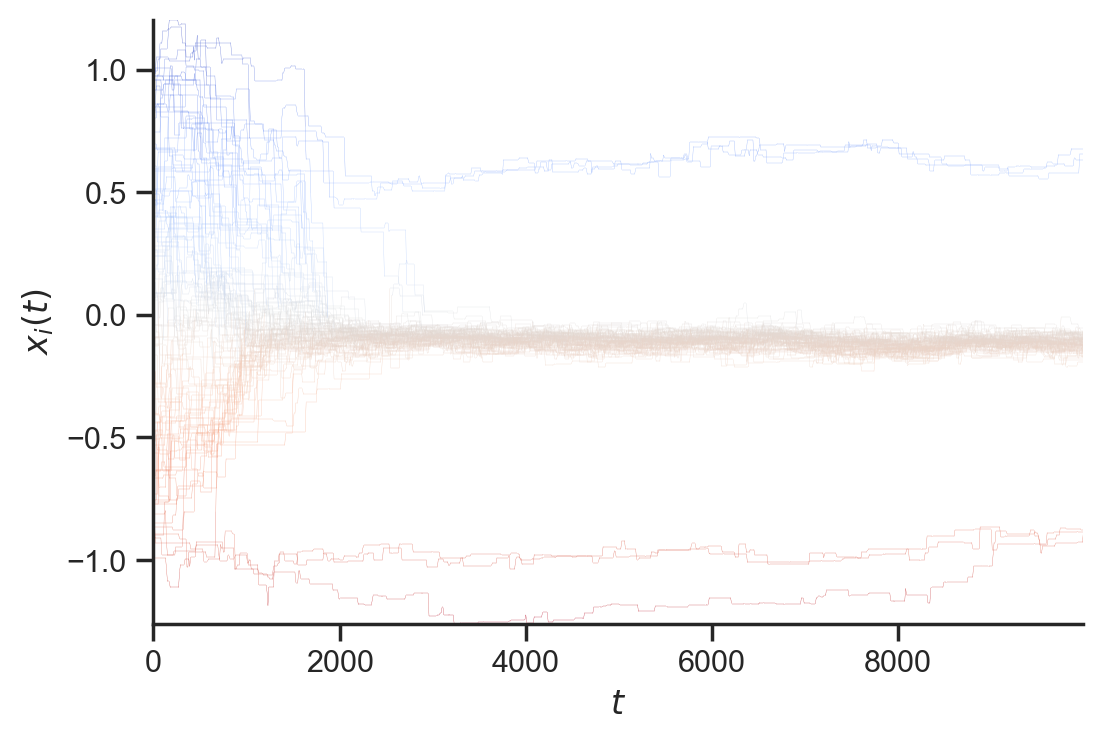

In [197]:
opinions = pd.read_csv(f"{d.data_dir}/data/opinions.csv.xz", index_col=0)
fig, ax = plot_agents(opinions, color_code='line', subsample=10)

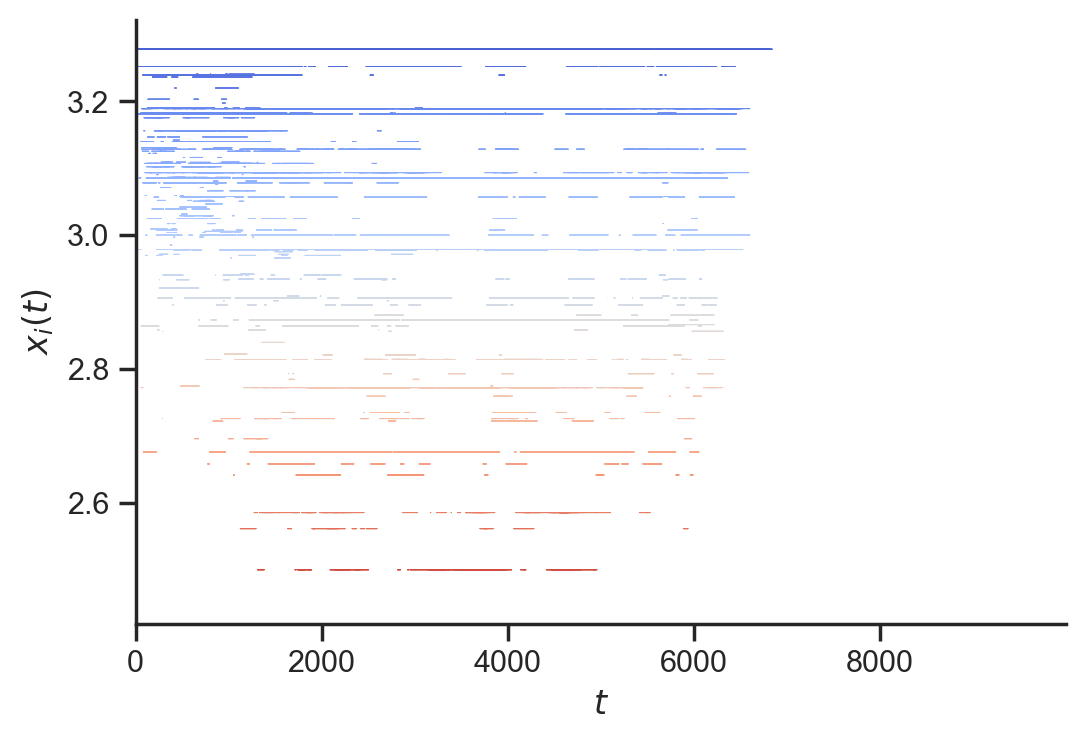

In [175]:
screen_diversity = pd.read_csv(f"{d.data_dir}/data/screen_diversity.csv.xz", index_col=0)
fig, ax = plot_agents(screen_diversity)
